In [48]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib import colors
from visualization import Visualizer2D as vis
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

In [2]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
import os 
print(os.getcwd())
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../ry/')
sys.path.append('../../')
sys.path.append('../')
import libry as ry
import time
import gc
import os
from collections import defaultdict
import utils

from webserver import sampleClient
import vision
import cv2

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
os.environ["ROS_IP"] = "129.69.216.155"
"""
total ERROR = 0.00241405
total ERROR after radius correction = 0.00221046
*** total Pinv:
[0.00180045, 5.51994e-06, -0.569533, -0.0330757,
 -1.82321e-06, -0.00133149, 1.00136, 0.125005,
 5.08217e-05, -0.00117336, -0.439092, 1.55487]
*** camera intrinsics K:
[555.197, -8.21031, -334.467,
 0, -563.526, -271.392,
 0, 0, -1.02162]
*** camera world pos: [-0.0330757, 0.125005, 1.55487]
*** camera world rot: [0.935411, 0.35328, -0.0133783, 0.00451155]
"""
cam_world_pos= [-0.0330757, 0.125005, 1.55487]
cam_world_rot= [0.935411, 0.35328, -0.0133783, 0.00451155]
chestCamIntrinsics = {'fx': 555.197 , 
                       'fy':  -563.526, 
                       'cx': -334.467, 
                       'cy': -271.392, 'width': 640, 'height':480}
cam_rot = [0.935411, 0.35328, -0.0133783, 0.00451155]
K = np.array([
[555.197, -8.21031, -334.467],
 [0, -563.526, -271.392],
 [0, 0, -1.02162]
])
pinv_chest = np.array([[0.00180045, 5.51994e-06, -0.569533, -0.0330757],
  [-1.82321e-06, -0.00133149, 1.00136, 0.125005],
  [5.08217e-05, -0.00117336, -0.439092, 1.55487]])

/home/niklas/git/uni/robotics-course/practical/clean


/home/niklas/.local/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [3]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../rai-robotModels/baxter/baxter_new.g')
cam = C.addObject(name="cam", parent="base_footprint", shape=ry.ST.sphere, size=[0.01], color=[0,1,0], pos=cam_world_pos, quat=cam_world_rot)
nodeName = "camMarc"

q_home = C.getJointState()
q_zero = q_home.copy() * 0.
B = C.operate(nodeName)
B.sync(C)
C.makeObjectsConvex()
B.sendToReal(False)
cam = ry.Camera("camMarc", "/camera/rgb/image_rect_color", "/camera/depth/image_rect_raw", True)

In [102]:
def check_target(targetFrame):
    if not targetFrame in C.getFrameNames():
        frame = C.addObject(name=targetFrame, parent="base_footprint" ,shape=ry.ST.sphere, size=[.01], pos=[0,0,0], color=[0.,0.,1.])
    return C.frame(targetFrame)

def close_pj(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-2] = 0.04
    else:
        q[-2] = 0
    B.moveHard(q)
    
def close_suction(close=True):
    B.sync(C)
    q = C.getJointState()
    if close:
        q[-1] = 0.1
    else:
        q[-2] = 0
    B.moveHard(q)

def plan_path_pj(targetPos, angle, targetFrame, gripperFrame, steps, time):
    intermediatePos = [targetPos[0], targetPos[1], targetPos[2] + 0.1]
    intermediate = check_target("intermediate")
    target = check_target(targetFrame)
    axis = pinv_chest @ np.array([0, 0, 1, 1])
    r = R.from_quat([axis[0]*np.sin(-angle/2), axis[1]*np.sin(-angle/2), axis[2]*np.sin(-angle/2), np.cos(angle/2)])
    angle_z = (r.as_euler('zyx'))[0]
    rotM = utils.rotz(angle_z)
    print("anglez:", angle_z)
    quat = utils.rotm2quat(rotM)
    B.sync(C)
    target.setPosition(targetPos)
    target.setQuaternion(quat)
    intermediate.setPosition(intermediatePos)
    pp = C.komo_path(1, steps, time, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.scalarProductZZ, frames=[gripperFrame, targetFrame], target= [1], time= [.5, 1])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductYZ, frames=[gripperFrame, targetFrame], target=[0], time=[.5, 1])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.distance, frames= [gripperFrame, 'intermediate'], target= [0], time= [.5])
    pp.addObjective(type= ry.OT.eq, feature= ry.FS.positionDiff, frames= [gripperFrame, targetFrame], target=[0,0,0],time= [1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

def plan_path_suction(targetPos, targetFrame, gripperFrame, steps, time):
    f = check_target(targetFrame)
    f.setPosition(targetPos)
    B.sync(C)
    pp = C.komo_path(1, steps, time, False)
    pp.setConfigurations(C)
    pp.clearObjectives()
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=[targetFrame, gripperFrame], target=[0, 0, -0.1], scale=[1], time=[.5])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.scalarProductZZ, frames=[targetFrame, gripperFrame], target=[1], scale=[1], time=[.5, 1.])
    pp.addObjective(type=ry.OT.eq, feature=ry.FS.positionDiff, frames=[targetFrame, gripperFrame], target=[0, 0, 0.02],scale=[1], time=[ 1.])
    pp.addObjective(type= ry.OT.sos, feature= ry.FS.qItself,order=1, frames= [], target=[],time= [], scale=[1])
    pp.optimize(False)
    t = pp.getT()
    path = []
    for i in range(t):
        frames = pp.getConfiguration(i)
        C.setFrameState(frames)
        q = C.getJointState()
        q[-2] = 0
        q[-1] = 0
        path += [q]
    return path, pp

In [129]:
img = cam.getRgb()
d = cam.getDepth()
dm, m = vision.maskDepth(d, 0.7,1.4 )
m = cv2.medianBlur(m.astype(np.uint8), 5)
segmask = sampleClient.predictMask(d)
print("sampled mask")
image = img.copy()
rcolors = np.random.randint(0, len(STANDARD_COLORS), size=len(segmask["masks"]))
for i, mask in enumerate(segmask["masks"]):
    c = colors.to_rgb(STANDARD_COLORS[rcolors[i]])
    mask = np.bitwise_and(mask.astype(np.bool), m.astype(np.bool))
    colored = np.ones((*mask.shape, 3)) * c
    colored[~mask.astype(np.bool)] = 0
    image = cv2.addWeighted(image.astype(np.uint8),1, (colored * 255).astype(np.uint8), 0.9, 0)

gx = 0
gy = 0
ind = 0
clicked = False
def mouse_callback(event, x, y, flags, params):

    #right-click event value is 2
    if event == 1:
        global gx, gy, ind, clicked

        #store the coordinates of the right-click event

        gx = x
        gy = y
        #this just verifies that the mouse data is being collected
        #you probably want to remove this later
        for i, mask in enumerate(segmask["masks"]):
            if mask[y, x]:
                ind = i
                print(ind)
                clicked = True
                break

#set mouse callback function for window
scale_width = 640 / image.shape[1]
scale_height = 480 / image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(image.shape[1] * scale)
window_height = int(image.shape[0] * scale)
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', window_width, window_height)
cv2.setMouseCallback('image', mouse_callback)
print("click")
while not clicked:
    cv2.imshow('image',image)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('a'):
        print (gx,gy)
print("sampling grasp type")
B.moveHard(q_home)
if grasp_type is None: 
    pj = sampleClient.predictFCGQCNN_pj(img, d, segmask["masks"][ind],host="http://multitask.ddnss.de:5000", **chestCamIntrinsics)
    suction = sampleClient.predictFCGQCNN_suction(img, d,host="http://multitask.ddnss.de:5000", segmask=segmask["masks"][ind], **chestCamIntrinsics)
    print("sample grasp")
    print("suction: {}, pj: {}".format(suction["q"], pj["q"]))
    if suction["q"] > pj["q"]:
        grasp_type="suction"
        grasp = suction
        p, pp = plan_path_suction(x, "suction", "baxterL", steps, times)
    else:
        grasp_type = "pj"
        grasp = pj
        p, pp = plan_path_pj(x, grasp["angle"], "pj", "baxterR", steps, times)
elif grasp_type == "suction":
    suction = sampleClient.predictFCGQCNN_suction(img, d,host="http://multitask.ddnss.de:5000", segmask=segmask["masks"][ind], **chestCamIntrinsics)
    grasp = suction
else:
    pj = sampleClient.predictFCGQCNN_pj(img, d,segmask["masks"][ind], host="http://multitask.ddnss.de:5000",**chestCamIntrinsics)
    grasp = pj
grasp_p, x, y = vision.getGraspPosition_noIntr(d,grasp["x"], grasp["y"], depthVal=grasp["depth"])
x = pinv_chest @ np.array(list(grasp_p) + [1])
if grasp_type == "suction":
    p, pp = plan_path_suction(x, "suction", "baxterL", steps, times)
else:
    print("pj")
    p, pp = plan_path_pj(x, grasp["angle"], "pj", "baxterR", steps, times)
print("done")

sampled mask
click
2
sampling grasp type
done


In [86]:
grasp_type =None; steps= 10; times=10

In [130]:
B.move(p, [times/steps * i for i in range(len(p))], False)

In [137]:
close_suction(True)

In [128]:
B.sendToReal(True)
B.moveHard(q_home)

In [69]:
q_copy = C.getJointState()



{'angle': 1.2762720155208536,
 'approachAngle': 0.0,
 'approachAxis': [0.0, 0.0, 1.0],
 'axis': [0.29028467725446233, 0.29028467725446233],
 'depth': 0.9532188228331506,
 'q': 0.9261975288391113,
 'type': 'pj',
 'width': 0.1,
 'x': 304.0,
 'y': 236.0}

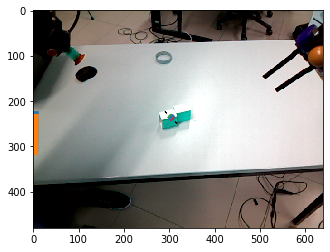

In [74]:
x = grasp["x"]; y=grasp["y"]
data = np.array([x, y])
plt.scatter(x,y)
axis=np.array([np.cos(grasp["angle"]), np.cos(grasp["angle"])])
width_px = 10
g1= data - (width_px/2) * axis
g2= data + (width_px/2) * axis
g1p = g1 - 2* 5
g2p = g2 + 2* 5
plt.plot([[g1[0], g2[0]], [g1[1], g2[1]]],linewidth=10)
# direction of jaw line
jaw_dir = 5 * np.array([axis[1], -axis[0]])

# length of arrow
alpha = 2*(5 - 2)

# plot first jaw
g1_line = np.c_[g1p, g1 - 2*2*axis].T
plt.arrow(g1p[0], g1p[1], alpha*axis[0], alpha*axis[1])
jaw_line1 = np.c_[g1 + jaw_dir, g1 - jaw_dir].T

plt.plot(jaw_line1[:,0], jaw_line1[:,1]) 

# plot second jaw
g2_line = np.c_[g2p, g2 + 10*axis].T
plt.arrow(g2p[0], g2p[1], -alpha*axis[0], -alpha*axis[1])
jaw_line2 = np.c_[g2 + jaw_dir, g2 - jaw_dir].T
plt.plot(jaw_line2[:,0], jaw_line2[:,1])
plt.imshow(img)